第一部分 数据预处理

In [ ]:
# 数据预处理函数定义
import csv
import os
import math
import numpy as np

def process_new2(input_file, output_file):
    csvfile=open(output_file, 'w',newline='')
    writer=csv.writer(csvfile)
    #writer.writerow(["id","id_num","id_dis","last_id","last_interval","interval",
                     #"data0","data1","data2","data3","data4","data5","data6","data7","data_c","data_last","isFirst","class"])
    id_num={} # id:次数
    id_t={}   # id:[时间戳,]
    id_data={} # id:[数据字段] 不管重不重复，按顺序记录
    # id_data2={} # id:[数据字段], 不管重不重复，按顺序记录
    # 上一条id
    idd = "0x000"
    # 上一条时间
    last_time = 0
    # 同id的上一条报文信息字典
    #last_same_id = {}
    # 记录上一个信息熵
    #data_c = 0
    # 数据字段，需要转成十进制
    data = []
    for i in range(0,8):
        data.append(0)
    # 上一条报文的数据字段、上一条同id报文的数据字段
    last_data = '0x0000000000000000'
    last_id_data = '0x0000000000000000'

    with open(input_file, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            # isFirst, 数据字段之前是否出现过, 1代表是第一次出现
            isFirst = 1
            # 处理数字字段的转换
            num = int(row[2])
            # 拼接数据字段得到的字符串
            dataString = ''
            for j in range(0,num):
                data[7-j] = eval("0x"+row[2+num-j])
                dataString = dataString + row[2+num-j]   
            # 第一次出现该id    
            if "0x"+row[1] not in id_num:
                time = [float(row[0])]
                dlc = [dataString]
                id_t["0x"+row[1]] = time
                id_data["0x"+row[1]] = dlc
                id_num["0x"+row[1]] = len(time) # 字典元素个数
                # last_same_id["0x"+row[1]] = 0
                interval = 0
                last_id_data = '0x0000000000000000'
            # 之前出现过该id
            else:
                time = id_t["0x"+row[1]]
                dlc = id_data["0x"+row[1]]
                last_id_data = '0x' + dlc[-1] 
                interval = float(row[0]) - time[-1]
                for i in time:
                    if float(row[0]) - i > 1:   # 去除时间间隔超过1s的
                        time.remove(i)
                    else:
                        break
                time.append(float(row[0]))
                if dataString not in dlc: # 数据字段之前没有出现过
                    isFirst = 1
                else:
                    isFirst = 0
                dlc.append(dataString)
                id_data.update({"0x"+row[1]:dlc})
                id_t.update({"0x"+row[1]:time})
                id_num.update({"0x"+row[1]:len(time)})
                # last_same_id.update({"0x"+row[1]:calc_ent(np.array(row[3:-1]))})
            last_interval = float(row[0]) - last_time
            id_dis = eval("0x"+row[1])^eval(idd) # 与前一个id的异或
            # d = calc_ent(np.array(row[3:-1])) # 某条报文数据字段形成的矩阵，如['d8', '00', '00', '8b', '00', '00', '00', '00']

            # 打标签
            if row[-1] == "R":
                writer.writerow([eval("0x"+row[1]),id_num["0x"+row[1]],id_dis,eval(idd),last_interval,interval,
                                 data[0],data[1],data[2],data[3],data[4],data[5],data[6],data[7],
                                 bin(int('0x'+dataString,16)^int(last_data,16)).count('1'),
                                 bin(int('0x'+dataString,16)^int(last_id_data,16)).count('1'),isFirst,'R'])
            else:
                writer.writerow([eval("0x"+row[1]),id_num["0x"+row[1]],id_dis,eval(idd),last_interval,interval,
                                 data[0],data[1],data[2],data[3],data[4],data[5],data[6],data[7],
                                 bin(int('0x'+dataString,16)^int(last_data,16)).count('1'),
                                 bin(int('0x'+dataString,16)^int(last_id_data,16)).count('1'),isFirst,'T'])
            # data_c = d
            idd = "0x"+row[1]
            for j in range(0,8):
                data[j]=0
            last_time = float(row[0])
            #last_same_id.update({"0x"+row[1]:calc_ent(np.array(row[3:-1]))})
            last_data = '0x' + dataString 
    f.close()
    csvfile.close()
    print("done")

In [ ]:
# 对3种攻击文件进行预处理
process_new2('DoS Attack_dataset.csv','DoS3.csv')
process_new2('Fuzzy Attack_dataset.csv','Fuzzy3.csv')
process_new2('Spoofing the drive gear_dataset.csv','SpoofingGEAR3.csv')

In [6]:
# 构造训练集和测试集，训练时从训练集中划分验证集
# 训练集：4个数据集各取30万条，标签：正常0，Fuzzy1，Dos2，Spoofing3
# 测试集：4个数据集各取10万条
import csv
import os
import math
import numpy as np

train_output_file = open('./multiply_train_final.csv', 'w',newline='')
test_output_file = open('./multiply_test_final.csv', 'w',newline='')
train_writer_file = csv.writer(train_output_file)
test_writer_file = csv.writer(test_output_file)
train_writer_file.writerow(["id","id_num","id_dis","last_id","last_interval","interval",
                     "data0","data1","data2","data3","data4","data5","data6","data7","data_c","data_last","isFirst","class"])
test_writer_file.writerow(["id","id_num","id_dis","last_id","last_interval","interval",
                     "data0","data1","data2","data3","data4","data5","data6","data7","data_c","data_last","isFirst","class"])

currentNum=0
trainNum=300000
testNum=100000

print("1.Fuzzy")
with open('Fuzzy3.csv', 'r') as f:
    reader=csv.reader(f)
    for row in reader:
        # 跳过第一行
        if row[0] == 'id':
            continue
        if currentNum < trainNum:
            if row[-1] == 'R':
                train_writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],
                                  row[9],row[10],row[11],row[12],row[13],row[14],row[15],row[16],'T0'])
            else:
                train_writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],
                                  row[9],row[10],row[11],row[12],row[13],row[14],row[15],row[16],'T1']) # Fuzzy:1
        elif currentNum < trainNum + testNum:
            if row[-1] == 'R':
                test_writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],
                                  row[9],row[10],row[11],row[12],row[13],row[14],row[15],row[16],'T0'])
            else:
                test_writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],
                                  row[9],row[10],row[11],row[12],row[13],row[14],row[15],row[16],'T1']) # Fuzzy:1
        else:
            break
        currentNum=currentNum+1
currentNum=0
f.close()

print("2.DoS")
with open('DoS3.csv', 'r') as f:
    reader=csv.reader(f)
    for row in reader:
        # 跳过第一行
        if row[0] == 'id':
            continue
        if currentNum < trainNum:
            if row[-1] == 'R':
                train_writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],
                                  row[9],row[10],row[11],row[12],row[13],row[14],row[15],row[16],'T0'])
            else:
                train_writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],
                                  row[9],row[10],row[11],row[12],row[13],row[14],row[15],row[16],'T2']) # DoS:2
        elif currentNum < trainNum + testNum:
            if row[-1] == 'R':
                test_writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],
                                  row[9],row[10],row[11],row[12],row[13],row[14],row[15],row[16],'T0'])
            else:
                test_writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],
                                  row[9],row[10],row[11],row[12],row[13],row[14],row[15],row[16],'T2']) # DoS:2
        else:
            break
        currentNum=currentNum+1
currentNum=0
f.close()

print("3.SpoofingGEAR")
with open('SpoofingGEAR3.csv', 'r') as f:
    reader=csv.reader(f)
    for row in reader:
        # 跳过第一行
        if row[0] == 'id':
            continue
        if currentNum < trainNum:
            if row[-1] == 'R':
                train_writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],
                                  row[9],row[10],row[11],row[12],row[13],row[14],row[15],row[16],'T0'])
            else:
                train_writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],
                                  row[9],row[10],row[11],row[12],row[13],row[14],row[15],row[16],'T3']) # Spoofing: 3
        elif currentNum < trainNum + testNum:
            if row[-1] == 'R':
                test_writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],
                                  row[9],row[10],row[11],row[12],row[13],row[14],row[15],row[16],'T0'])
            else:
                test_writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],
                                  row[9],row[10],row[11],row[12],row[13],row[14],row[15],row[16],'T3']) # Spoofing: 3
        else:
            break
        currentNum=currentNum+1
currentNum=0
f.close()

train_output_file.close()
test_output_file.close()
print("done")

1.Fuzzy
2.DoS
3.SpoofingGEAR
done


第二部分 输入训练集，训练模型，找出最优迭代轮数，确定和保存模型

In [7]:
# 训练并确定模型，并保存
# 训练过程结果可不输出
import os
import numpy as np
import keras as K
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
from keras.layers import LSTM, Dense, Activation,Input,core,Dropout
from keras.models import Model
from keras.callbacks import Callback
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

# 读取CSV数据集，并拆分为训练集和测试集
# 该函数的传入参数为CSV_FILE_PATH: csv文件路径

def TP(y_true,y_pred):
    TP=tf.reduce_sum(y_true*tf.round(y_pred))
    return TP

def TN(y_true,y_pred):
    TN=tf.reduce_sum((1-y_true)*(1-tf.round(y_pred)))
    return TN

def FP(y_true,y_pred):
    FP=tf.reduce_sum((1-y_true)*tf.round(y_pred))
    return FP

def FN(y_true,y_pred):
    FN=tf.reduce_sum(y_true*(1-tf.round(y_pred)))
    return FN

class LossHistory(K.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

def load_data(CSV_FILE_PATH, size1, size2):
    CAN = pd.read_csv(CSV_FILE_PATH)
    target_var = 'class'  # 目标变量
    # 数据集的特征
    features = list(CAN.columns)
    features.remove(target_var)
    features.remove('id_dis')
    # 目标变量的类别
    Class = CAN[target_var].unique()
    # 目标变量的类别字典
    Class_dict = dict(zip(Class, range(len(Class))))
    # 增加一列target, 将目标变量进行编码
    CAN['target'] = CAN[target_var].apply(lambda x: Class_dict[x])
    # 对目标变量进行0-1编码(One-hot Encoding)
    lb = LabelBinarizer()
    lb.fit(list(Class_dict.values()))
    transformed_labels = lb.transform(CAN['target'])
    y_bin_labels = []  # 对多分类进行0-1编码的变量
    for i in range(transformed_labels.shape[1]):
        y_bin_labels.append('y' + str(i))
        CAN['y' + str(i)] = transformed_labels[:, i]
    # 将数据集分为训练集和验证集
    train_x, val_x, train_y, val_y = train_test_split(CAN[features], CAN[y_bin_labels], \
                                                        train_size=size1, test_size=size2, random_state=0) # shuffle=True, stratify=None
    print(type(Class_dict))
    print(Class_dict)
    return train_x, val_x, train_y, val_y, Class_dict


# 0. 开始
print("\nCAN dataset using Keras/TensorFlow ")
np.random.seed(4)
tf.random.set_seed(13)

# 1. 读取CSV数据集
print("Loading CAN data into memory")
CSV_FILE_PATH = './multiply_train_final.csv'
train_x, val_x, train_y, val_y, Class_dict = load_data(CSV_FILE_PATH, 0.9, 0.1)
train_x = train_x.values.reshape(train_x.shape[0],1,16)
val_x = val_x.values.reshape(val_x.shape[0],1,16)


# 2. 定义模型
init = K.initializers.glorot_uniform(seed=1)
simple_adam = K.optimizers.Adam()
model = K.models.Sequential()
model.add(LSTM(units=256,input_shape=(1, 16),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=128,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=32, kernel_initializer=init, activation='linear'))
model.add(Dense(4,activation='softmax'))
#model.add(Activation('tanh'))
#model.add(K.layers.Dense(units=6, kernel_initializer=init, activation='relu'))
#model.add(K.layers.Dense(units=2, kernel_initializer=init, activation='sigmoid'))
#model.compile(loss='categorical_crossentropy', optimizer=simple_adam, metrics=['accuracy'])'''
#rmsprop = RMSprop(lr=0.01)
#model.compile(loss='mae', optimizer='rmsprop', metrics=['accuracy',TP,TN,FP,FN])
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
#print(model.summary())
# 3. 训练模型
b_size = 64
max_epochs = 20
# max_epochs = 2
history = LossHistory()
print("Starting training ")
h = model.fit(train_x, train_y, batch_size=b_size, epochs=max_epochs, shuffle=True, verbose=1,callbacks=[history], validation_data=(val_x, val_y))
# model.save("./lstm_multi_final.h5")


CAN dataset using Keras/TensorFlow 
Loading CAN data into memory
<class 'dict'>
{'T0': 0, 'T1': 1, 'T2': 2, 'T3': 3}
Starting training 
Epoch 1/20
12657/12657 [==============================] - 99s 8ms/step - loss: 0.0124 - accuracy: 0.9970 - val_loss: 0.0038 - val_accuracy: 0.9994
Epoch 2/20
12657/12657 [==============================] - 98s 8ms/step - loss: 0.0063 - accuracy: 0.9989 - val_loss: 0.0055 - val_accuracy: 0.9993
Epoch 3/20
12657/12657 [==============================] - 98s 8ms/step - loss: 0.0066 - accuracy: 0.9990 - val_loss: 0.0046 - val_accuracy: 0.9993
Epoch 4/20
12657/12657 [==============================] - 98s 8ms/step - loss: 0.0064 - accuracy: 0.9990 - val_loss: 0.0059 - val_accuracy: 0.9991
Epoch 5/20
12657/12657 [==============================] - 96s 8ms/step - loss: 0.0064 - accuracy: 0.9990 - val_loss: 0.0051 - val_accuracy: 0.9991
Epoch 6/20
12657/12657 [==============================] - 94s 7ms/step - loss: 0.0066 - accuracy: 0.9991 - val_loss: 0.0055 - va

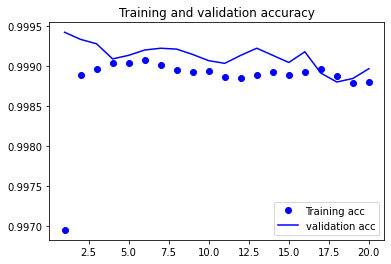

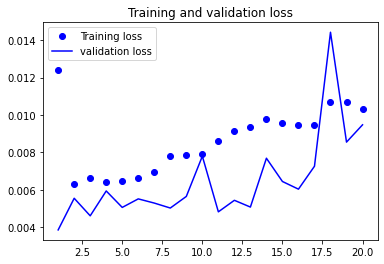

[0.0038462134543806314, 0.005539278034120798, 0.004600683692842722, 0.005930083338171244, 0.00505024055019021, 0.005506544373929501, 0.005282422993332148, 0.005017001181840897, 0.005638128146529198, 0.0077916583977639675, 0.004813791252672672, 0.005430659279227257, 0.005068838130682707, 0.007681648246943951, 0.006437224801629782, 0.006026832386851311, 0.0072532715275883675, 0.014422506093978882, 0.008544129319489002, 0.00946967862546444]
20
0.0038462134543806314 0
12657/12657 [==============================] - 94s 7ms/step - loss: 0.0105 - accuracy: 0.9987 - val_loss: 0.0078 - val_accuracy: 0.9991


In [14]:
# 展示训练结果
import matplotlib.pyplot as plt
acc = h.history['accuracy']
loss = h.history['loss']
val_acc = h.history['val_accuracy']
val_loss = h.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 根据验证集最小损失确定迭代轮数，确定并保存模型
print(val_loss)
print(len(val_loss))
min_num = val_loss[0]
min_index = 0
for i in range(len(val_loss)):
    if val_loss[i] < min_num:
        min_num = val_acc[i]
        min_index = i

print(min_num,min_index)

h = model.fit(train_x, train_y, batch_size=b_size, epochs=min_index+1, shuffle=True, verbose=1,callbacks=[history], validation_data=(val_x, val_y))
model.save("./lstm_multi_final.h5")

第三部分 输入测试集，展示效果

In [17]:
# 测试，展示测试结果
# 为了和网站匹配及展示的方便，使用刚刚保存的模型
from keras.models import load_model
# 0. 开始
print("\nCAN dataset using Keras/TensorFlow ")
np.random.seed(4)
tf.random.set_seed(13)

# 1. 读取CSV数据集
print("Loading CAN data into memory")
CSV_FILE_PATH = './multiply_test_final.csv'
train_x, test_x, train_y, test_y, Class_dict = load_data(CSV_FILE_PATH, 0.01, 0.99)
#train_x = train_x.values.reshape(train_x.shape[0],1,16)
test_x = test_x.values.reshape(test_x.shape[0],1,16)

# 加载刚刚保存的模型
final_model = load_model('./lstm_multi_final.h5')
# 测试模型的结果
eval2 = model.evaluate(test_x, test_y, verbose=0)
print('测试集上的loss和acc：')
print(eval2)


CAN dataset using Keras/TensorFlow 
Loading CAN data into memory
<class 'dict'>
{'T0': 0, 'T1': 1, 'T2': 2, 'T3': 3}
测试集上的loss和acc：
[0.004908901639282703, 0.9994276165962219]


In [18]:
# 
predictions = final_model.predict(test_x)
from sklearn.metrics import classification_report
print(classification_report(test_y.values.argmax(axis=-1), predictions.argmax(axis=-1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    247114
           1       1.00      0.99      0.99     15926
           2       1.00      1.00      1.00     18044
           3       1.00      1.00      1.00     15916

    accuracy                           1.00    297000
   macro avg       1.00      1.00      1.00    297000
weighted avg       1.00      1.00      1.00    297000



In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_y.values.argmax(axis=-1), predictions.argmax(axis=-1))